# 一、引言
在前面一篇文章复现LLM：带你从零训练tokenizer中我们训练了一个分词器，并通过分词器的序列化方法得到了文本的token_id序列表示。

但是在深度学习中，许多算法（例如：注意力）都需要对输入数据进行距离和相似度计算，而离散的token_id序列本身并没有距离和相似度的概念，例如100和101两个token_id虽然数值接近，但并不表示这两个token_id相似。

因此，我们通常会将离散的token映射到一个高维的、连续的向量空间，这样就允许我们使用线性代数中的操作（如加法、点积）进行计算

# 二、词嵌入
通常，会使用嵌入层将 token 嵌入到连续的向量表示中。这些用来转换词符的嵌入层是大语言模型（LLM）的一部分，并且在模型训练的过程中会不断调整和优化。

假设我们有一个只包含6个单词的小型词汇表，我们想要创建大小为3的嵌入，那么嵌入层可以用以下方式创建。

In [1]:
import torch

vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
embedding_layer.weight

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)

In [2]:
embedding_layer

Embedding(6, 3)

如果要对tokenid为3的词进行向量嵌入，则如下

In [4]:
embedding_layer(torch.tensor([3]))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)

如果要对序列化结果为[5,2,3,1]的token序列进行嵌入，可以表示为：

In [6]:
input_ids = torch.tensor([5,2,3,1])
embedding_layer(input_ids)

tensor([[-2.8400, -0.7849, -1.4096],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)

> 如上面两个例子所看到的结果，嵌入本质上是一种查找操作，通过分词后的token_id直接在权重矩阵中进行索引查找，这种方式比通过独热编码进行矩阵乘法要更为高效。

如果要对两个序列组成的批次进行嵌入，则可以表示为：

In [7]:
batch = torch.tensor([[1, 2], [2, 3]])
embedding_layer(batch)

tensor([[[ 0.9178,  1.5810,  1.3010],
         [ 1.2753, -0.2010, -0.1606]],

        [[ 1.2753, -0.2010, -0.1606],
         [-0.4015,  0.9666, -1.1481]]], grad_fn=<EmbeddingBackward0>)

In [9]:
embedding_layer(batch).shape

torch.Size([2, 2, 3])

> 经过嵌入后，张量会增加一个嵌入维度，例如上面示例中的张量形状由[4]变成了[4,3],多出的维度3即为嵌入维度。

嵌入层在创建时只初始化了一些随机数值，但它会作为神经网络的一部分，通过反向传播算法进行训练和优化，并不断的进行调整，以更好的表示输入数据。

# 三、位置嵌入
上面的Embedding生成方式有个不足，相同的token ID总是被映射成相同的向量表示，并没有关注token ID在输入序列中的位置。所以一个token不论其在输入序列中的位置如何，嵌入层都会将其转换为相同的向量表示（如下面[5,1,5]序列中两个5嵌入向量表示）。
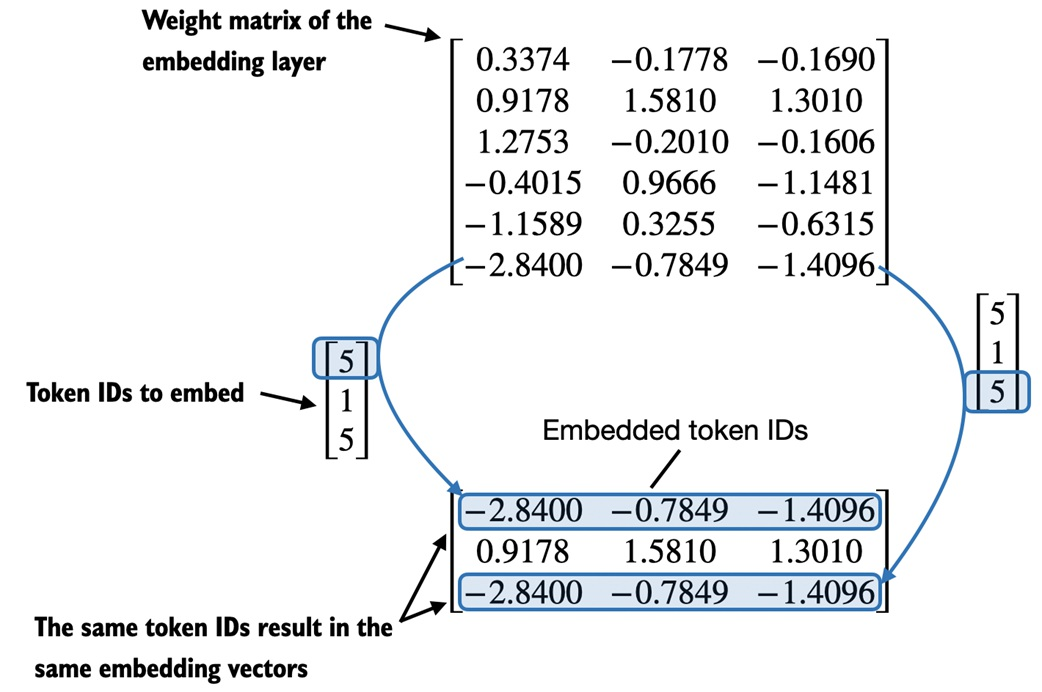

但人类的自然语言其实是关心位置和顺序的，例如我在你家和你在我家这两个文本的token完全相同，只是我和你两个token的位置不同，就表达了两个完全不同的含义。

由于LLM的自注意力机制本身也不关注位置（计算注意力得分时的点积操作只和向量自身有关，与位置无关），所以将位置注入到输入向量中是有帮助的。

通常有两种常用的位置编码方式：绝对位置编码和相对位置编码。

## 3.1 绝对位置编码

绝对位置编码与序列中的特定位置相关联，可以简单理解为token在序列中的offset偏移。对于输入序列中的每个位置，都会添加一个唯一的位置编码到token的嵌入向量中。如下图所示（出于简化考虑，token的向量嵌入值都为1）：
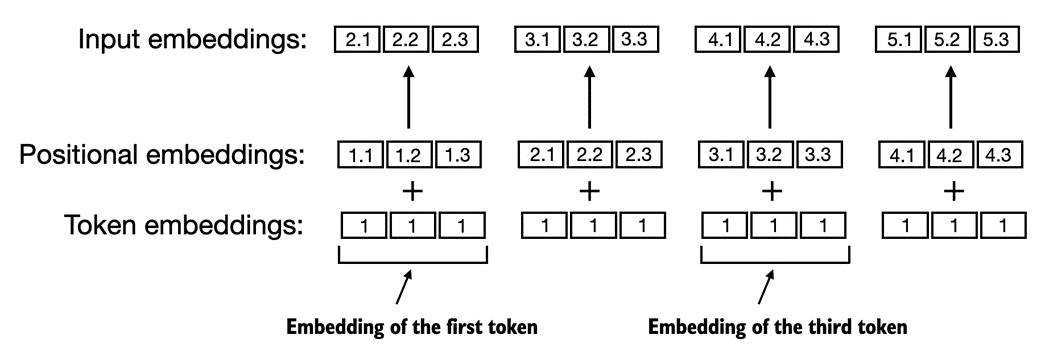
> 绝对位置编码主要在早期经典的transformer模型中使用，例如：GPT2模型使用的就是绝对位置编码，但它不是固定的，会在训练期间进行优化。

绝对位置编码的缺点在于：

1. 泛化性差，一个序列中的绝对位置难以应用到其它序列中，因为序列的上下文通常都是不同的。
2. 如何响应超出序列长度的位置？例如训练时用的是1024，而推理时用的是2048，会因为找不到对应的P2048位置信息而失效，长度外推极其困难。

与之对应的是相对位置编码，关注的不再是token的绝对位置，而是侧重于token之间的相对位置或距离，这意味着模型在训练过程中学习的是彼此之间有多远，而不是token在哪个确切位置。这样做的好处是，模型可以更好的推广到不同长度的序列。

业界目前最常用的位置编码方式是旋转位置编码。

## 3.2 旋转位置编码
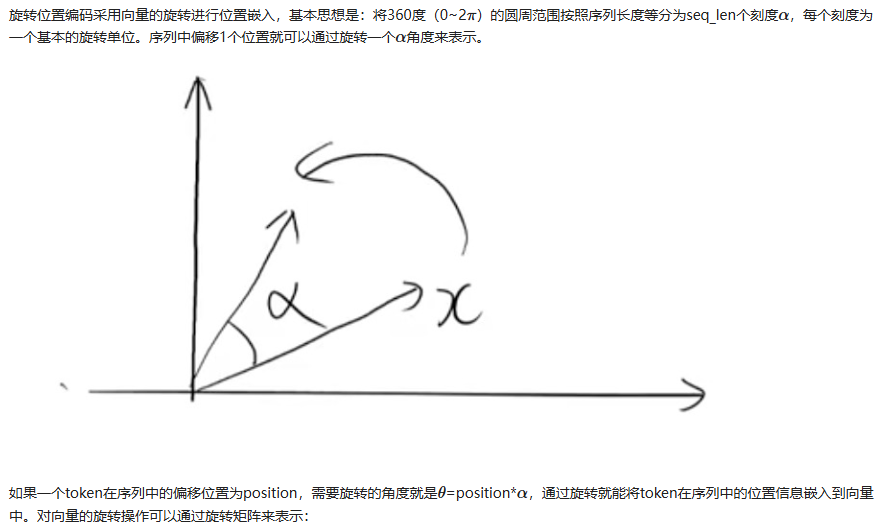
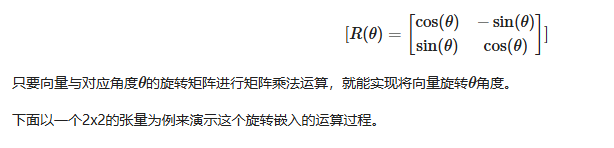

In [10]:
import torch
import math

input_embeddings = torch.tensor([[0.9178,  1.5810],   # 向量 1，假设对应token ’小‘  
                                  [1.2753, -0.2010]])  # 向量 2 ，假设对应token ’米‘

先假设序列长度为1024，下面定义一个rotate方法，作用是将输入的x向量旋转position个位置。

In [11]:
def rotate(x, position, max_len=1024):
    # 将圆周等分为max_len个刻度
    alpha = (2 * torch.pi) / max_len
    # 第position个位置对应的cos、sin值
    cos_theta = math.cos(alpha * position)
    sin_theta = math.sin(alpha * position)
    # 定义旋转矩阵
    ratation_matrix = torch.tensor([[cos_theta, -sin_theta],
                                   [sin_theta, cos_theta]])
    # 通过乘法矩阵来实现向量的旋转操作
    ratated_embeddings = torch.matmul(x, ratation_matrix)
    return ratated_embeddings

In [12]:
ratated_embedding_1 = rotate(input_embeddings[1], 1)
ratated_embedding_1

tensor([ 1.2740, -0.2088])

> 如上所示，我们对向量2作了1个偏移位置的旋转后，向量数值已经与原来的输入向量完全不同。

下面计算旋转前后向量的模是否发生变化。
> 注：向量的模，即向量的范数，所有元素平方和的平方根，可以用来表示向量在空间中的大小，pytorch中用torch.norm来计算向量模。

In [14]:
torch.norm(input_embeddings[1]), torch.norm(ratated_embedding_1)

(tensor(1.2910), tensor(1.2910))

可以看到，虽然旋转前后的向量已经完全不同，但向量的模却完全相同，这就是旋转的特性，旋转前后向量模不发生改变。

### 3.2.1 那这个特性具体有什么用途呢？

模型推理时有一个核心步骤计算自注意力，而自注意力则是通过点积操作来计算每两个token之间的注意力得分，点积操作在数学上可以表示为：
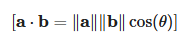
上面这个公式意味着，只要两个向量的模和向量之间的夹角保持不变，则向量的点积就保持不变。换句话说，两个token之间的注意力得分只和token之间的相对距离有关，与绝对位置无关。

下面我们来验证下，先计算当前input_embeddings中的两个词向量的点积，词向量一位置为0不需要旋转，词向量二旋转1个位置（即上面的rotated_embeddings_1)。

In [17]:
print("dot in input1:", torch.dot(input_embeddings[0], ratated_embedding_1))

dot in input1: tensor(0.8392)


接下来，我们在序列最前面加三个token，原来的两个token小和米向右偏移了3个位置，分别变成了向量4和向量5，如下所示。

In [18]:
input_embeddings2 = torch.tensor([
    [1.3010,  -0.1606],   # 向量 1，假设对应token’我‘ 
    [ 1.2753, -0.2010],   # 向量 2，假设对应token’爱‘
    [-0.4015,  0.9666],   # 向量 3，假设对应token’吃‘ 
    [0.9178,  1.5810],   # 向量 4，假设对应token’小‘  
    [1.2753, -0.2010]])  # 向量 5，假设对应token’米‘

那token 小 需要旋转3个位置来进行位置嵌入，token 米 需要旋转4个位置来进行位置嵌入。

In [19]:
rotated_embeddings = torch.stack([rotate(item, i) for i, item in enumerate(input_embeddings2)])
rotated_embeddings

tensor([[ 1.3010, -0.1606],
        [ 1.2740, -0.2088],
        [-0.3896,  0.9715],
        [ 0.9467,  1.5638],
        [ 1.2700, -0.2322]])

In [20]:
print("dot in input2:", torch.dot(rotated_embeddings[3], rotated_embeddings[4]))

dot in input2: tensor(0.8392)


可以看到，小和米两个token虽然在两个序列中的绝对位置不同，但由于相对距离没变，所以即使经过旋转位置嵌入后，两个token的点积依然保持不变。

> 旋转位置编码虽然嵌入的是每个token在序列中的绝对位置（角度），但token在序列中的上下文含义却可以做到只依赖相对位置。 这与我们人类理解一句话的方式是相似的，我爱吃小米这句话不论放在一段话前面、中间还是后面，基本不影响这句话的理解，但如果词的相对位置发生改变，例如米小就和小米就有着完全不同的含义，而这个含义的不同就通过位置嵌入来实现。

不仅如此，旋转位置嵌入还有以下好处：

1. 有界：0-360的旋转角度范围能解决序列长度无界的问题，不会出现绝对位置嵌入时位置随着序列长度无限大的问题。
2. 长度外推：0-360的角度范围理论上可以按任意序列长度切割，上下文1k切割为1024份，如果上下文10k则切割为10240份，它可以轻松外推到更大的上下文长度。

小结: 本文描述了词嵌入和位置嵌入的基本作法，通过词嵌入将离散token映射为连续的高维向量空间，使得token可以进行数学运算。通过旋转位置编码将token在序列中的位置信息嵌入到词向量中，使得更精确的计算token在序列中的上下文含义变得可能，两者均是复现语言模型的关键步骤。